## A pokedex- basically identifying pokemon's images

 we can source the required data using the bing api from microsoft.
 We can use the following commands for that :

###Step 1. install requests package for easy http requests
    $ pip install requests
    
###Step 2. Python script to download images
    # import the necessary packages
    from requests import exceptions
    import argparse
    import requests
    import cv2
    import os

    # construct the argument parser and parse the arguments
    ap = argparse.ArgumentParser()
    ap.add_argument("-q", "--query", required=True,
        help="search query to search Bing Image API for")
    ap.add_argument("-o", "--output", required=True,
        help="path to output directory of images")
    args = vars(ap.parse_args())
    
###Step 3. Configure some global variables
    # set your Microsoft Cognitive Services API key along with (1) the
    # maximum number of results for a given search and (2) the group size
    # for results (maximum of 50 per request)
    API_KEY = "YOUR_API_KEY_GOES_HERE"
    MAX_RESULTS = 250
    GROUP_SIZE = 50

    # set the endpoint API URL
    URL = "https://api.cognitive.microsoft.com/bing/v7.0/images/search"
    
###Step 4. Configuring exceptions
    # when attempting to download images from the web both the Python
    # programming language and the requests library have a number of
    # exceptions that can be thrown so let's build a list of them now
    # so we can filter on them
   
    


 EXCEPTIONS = set([IOError, FileNotFoundError,
        exceptions.RequestException, exceptions.HTTPError,
        exceptions.ConnectionError, exceptions.Timeout])
        

###Step 5. initialise search parameters:

    # store the search term in a convenience variable then set the
    # headers and search parameters
    term = args["query"]
    headers = {"Ocp-Apim-Subscription-Key" : API_KEY}
    params = {"q": term, "offset": 0, "count": GROUP_SIZE}

    # make the search
    print("[INFO] searching Bing API for '{}'".format(term))
    search = requests.get(URL, headers=headers, params=params)
    search.raise_for_status()

    # grab the results from the search, including the total number of
    # estimated results returned by the Bing API
    results = search.json()
    estNumResults = min(results["totalEstimatedMatches"], MAX_RESULTS)
    print("[INFO] {} total results for '{}'".format(estNumResults,
        term))

    # initialize the total number of images downloaded thus far
    total = 0

##loop over the estimated number of results in `GROUP_SIZE` groups
for offset in range(0, estNumResults, GROUP_SIZE):
	# update the search parameters using the current offset, then
	# make the request to fetch the results
	print("[INFO] making request for group {}-{} of {}...".format(
		offset, offset + GROUP_SIZE, estNumResults))
	params["offset"] = offset
	search = requests.get(URL, headers=headers, params=params)
	search.raise_for_status()
	results = search.json()
	print("[INFO] saving images for group {}-{} of {}...".format(
		offset, offset + GROUP_SIZE, estNumResults))

Saving images inn current batch	
    
    # loop over the results
	for v in results["value"]:
		# try to download the image
		try:
			# make a request to download the image
			print("[INFO] fetching: {}".format(v["contentUrl"]))
			r = requests.get(v["contentUrl"], timeout=30)
 
			# build the path to the output image
			ext = v["contentUrl"][v["contentUrl"].rfind("."):]
			p = os.path.sep.join([args["output"], "{}{}".format(
				str(total).zfill(8), ext)])
 
			# write the image to disk
			f = open(p, "wb")
			f.write(r.content)
			f.close()
 
		# catch any errors that would not unable us to download the
		# image
		except Exception as e:
			# check to see if our exception is in our list of
			# exceptions to check for
			if type(e) in EXCEPTIONS:
				print("[INFO] skipping: {}".format(v["contentUrl"]))
				continue

	#try to load the image from disk
		image = cv2.imread(p)
 
		# if the image is `None` then we could not properly load the
		# image from disk (so it should be ignored)
		if image is None:
			print("[INFO] deleting: {}".format(p))
			os.remove(p)
			continue
 
		# update the counter
		total += 1

#for example downloading dataset for squirtle
$ mkdir dataset/squirtle
$ python search_bing_api.py --query "squirtle" --output dataset/squirtle
[INFO] searching Bing API for 'squirtle'
[INFO] 250 total results for 'squirtle'
[INFO] making request for group 0-50 of 250...
[INFO] saving images for group 0-50 of 250...
[INFO] fetching: http://fc03.deviantart.net/fs71/i/2013/082/1/3/007_squirtle_by_pklucario-d5z1gj5.png
[INFO] fetching: http://fc03.deviantart.net/fs70/i/2012/035/b/2/squirtle_by_maii1234-d4oo1aq.jpg
[INFO] fetching: http://3.bp.blogspot.com/-yeK-y_dHCCQ/TWBkDZKi6vI/AAAAAAAAABU/_TVDXBrxrkg/s1600/Leo%2527s+Squirtle.jpg
...

this is done in commandline


In [2]:
from __future__ import division
import cv2
#to show the image
from matplotlib import pyplot as plt
import numpy as np
from math import cos, sin

In [3]:
green = (0, 255, 0)

In [4]:
def show(image):
    # Figure size in inches
    plt.figure(figsize=(10, 10))

    # Show image, with nearest neighbour interpolation
    plt.imshow(image, interpolation='nearest')

In [5]:
def overlay_mask(mask, image):
	#make the mask rgb
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    #calculates the weightes sum of two arrays. in our case image arrays
    #input, how much to weight each. 
    #optional depth value set to 0 no need
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    return img

In [6]:
def find_biggest_contour(image):
    # Copy
    image = image.copy()
    #input, gives all the contours, contour approximation compresses horizontal, 
    #vertical, and diagonal segments and leaves only their end points. For example, 
    #an up-right rectangular contour is encoded with 4 points.
    #Optional output vector, containing information about the image topology. 
    #It has as many elements as the number of contours.
    #we dont need it
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask

In [9]:
def circle_contour(image, contour):
    # Bounding ellipse
    image_with_ellipse = image.copy()
    #easy function
    ellipse = cv2.fitEllipse(contour)
    #add it
    cv2.ellipse(image_with_ellipse, ellipse, green, 2)
    return image_with_ellipse

True

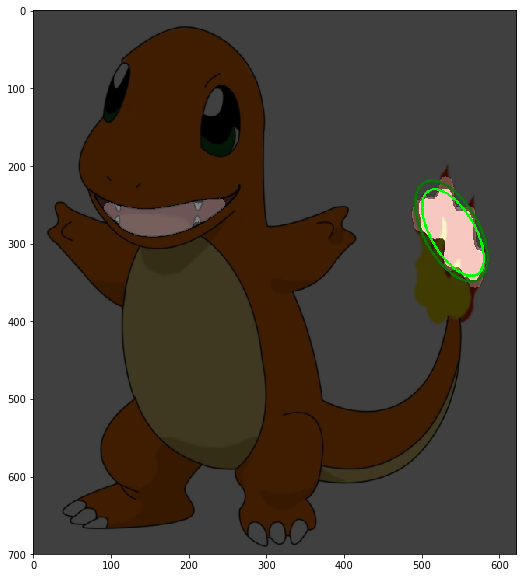

In [11]:
def find_strawberry(image):
    #RGB stands for Red Green Blue. Most often, an RGB color is stored 
    #in a structure or unsigned integer with Blue occupying the least 
    #significant “area” (a byte in 32-bit and 24-bit formats), Green the 
    #second least, and Red the third least. BGR is the same, except the 
    #order of areas is reversed. Red occupies the least significant area,
    # Green the second (still), and Blue the third.
    # we'll be manipulating pixels directly
    #most compatible for the transofrmations we're about to do
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Make a consistent size
    #get largest dimension
    max_dimension = max(image.shape)
    #The maximum window size is 700 by 660 pixels. make it fit in that
    scale = 700/max_dimension
    #resize it. same width and hieght none since output is 'image'.
    image = cv2.resize(image, None, fx=scale, fy=scale)
    
    #we want to eliminate noise from our image. clean. smooth colors without
    #dots
    # Blurs an image using a Gaussian filter. input, kernel size, how much to filter, empty)
    image_blur = cv2.GaussianBlur(image, (7, 7), 0)
    #t unlike RGB, HSV separates luma, or the image intensity, from
    # chroma or the color information.
    #just want to focus on color, segmentation
    image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)

    # Filter by colour
    # 0-10 hue
    #minimum red amount, max red amount
    min_red = np.array([0, 100, 80])
    max_red = np.array([10, 256, 256])
    #layer
    mask1 = cv2.inRange(image_blur_hsv, min_red, max_red)

    #birghtness of a color is hue
    # 170-180 hue
    min_red2 = np.array([170, 100, 80])
    max_red2 = np.array([180, 256, 256])
    mask2 = cv2.inRange(image_blur_hsv, min_red2, max_red2)

    #looking for what is in both ranges
    # Combine masks
    mask = mask1 + mask2

    # Clean up
    #we want to circle our strawberry so we'll circle it with an ellipse
    #with a shape of 15x15
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    #morph the image. closing operation Dilation followed by Erosion. 
    #It is useful in closing small holes inside the foreground objects, 
    #or small black points on the object.
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #erosion followed by dilation. It is useful in removing noise
    mask_clean = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)

    # Find biggest strawberry
    #get back list of segmented strawberries and an outline for the biggest one
    big_strawberry_contour, mask_strawberries = find_biggest_contour(mask_clean)

    # Overlay cleaned mask on image
    # overlay mask on image, strawberry now segmented
    overlay = overlay_mask(mask_clean, image)

    # Circle biggest strawberry
    #circle the biggest one
    circled = circle_contour(overlay, big_strawberry_contour)
    show(circled)
    
    #we're done, convert back to original color scheme
    bgr = cv2.cvtColor(circled, cv2.COLOR_RGB2BGR)
    
    return bgr

#read the image
image = cv2.imread('char.jpg')
#detect it
result = find_strawberry(image)
#write the new image
cv2.imwrite('char1.jpg', result)
